# Import Libraries

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from art.utils import load_mnist
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FeatureAdversariesTensorFlowV2

# Load Data

In [12]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

# Model

In [17]:
model = models.Sequential([
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10)
])

In [18]:
model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

# Train

In [19]:
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2473 - accuracy: 0.9253
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1141 - accuracy: 0.9653
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0839 - accuracy: 0.9736
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0689 - accuracy: 0.9777
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0572 - accuracy: 0.9818
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0480 - accuracy: 0.9847
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0426 - accuracy: 0.9859
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0371 - accuracy: 0.9879
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0337 - accuracy: 0.9893
Epoch 10/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.028

# Attack

In [20]:
art_model = TensorFlowV2Classifier(model=model, loss_object=CategoricalCrossentropy(from_logits=True), nb_classes=10, input_shape=(28, 28, 1), clip_values=(0, 1))

In [28]:
valid_indices = np.where(np.argmax(y_test, axis=1)[:100] != np.argmax(y_test, axis=1)[100:200])[0]
source = x_test[:100][valid_indices][:32]
guide = x_test[100:200][valid_indices][:32]

In [97]:
feat_adv = FeatureAdversariesTensorFlowV2(
    art_model,
    layer=-2,
    delta=25/255,
    optimizer=None,
    step_size=1/255,
    max_iter=100,
)

In [98]:
adv_test = feat_adv.generate(source, guide)

Feature Adversaries TensorFlow v2:   0%|          | 0/100 [00:00<?, ?it/s]

# Results

In [99]:
def calc_acc(preds):
    return np.sum(preds == np.argmax(y_test[:100][valid][:32], axis=1)) / len(y_test[:100][valid][:32])

In [100]:
safe_preds = np.argmax(art_model.predict(source), axis=1)

In [101]:
safe_acc = calc_acc(safe_preds)
print("Accuracy on test batch:", safe_acc)

Accuracy on test batch: 1.0


In [102]:
adv_preds = np.argmax(art_model.predict(adv_test), axis=1)

In [103]:
adv_acc = calc_acc(adv_preds)
pert = np.mean(np.amax(np.abs(source - adv_test), axis=(1, 2, 3)))

print("Accuracy on adversarial test batch: {}%".format(accuracy * 100))
print("Average perturbation: {}%".format(pert))

Accuracy on adversarial test batch: 0.0%
Average perturbation: 0.09803921568627452%


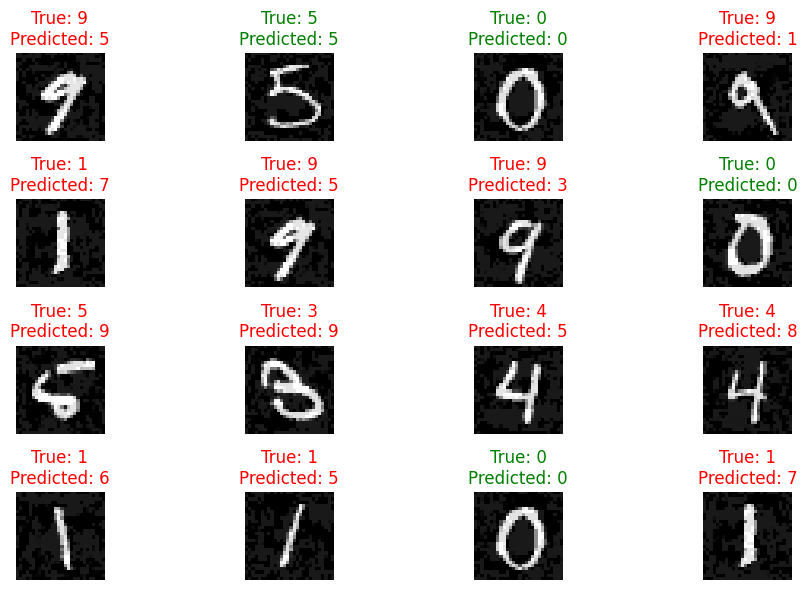

In [104]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(adv_test[random_index[i]].reshape(28, 28), cmap='gray')
    ax.axis('off')

    if np.argmax(y_test[random_index[i]], axis=0) == adv_preds[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {np.argmax(y_test[random_index[i]], axis=0)}\nPredicted: {adv_preds[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()